# **Sentiment Analysis on Amazon Fine Food Reviews**

In [116]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/amazon-fine-food-reviews/hashes.txt


### Importing Modules

In [117]:
%matplotlib inline
import numpy as np 
import pandas as pd
import sqlite3 as sql
import nltk
import string
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



### Reading SQL using SQLITE3

In [ ]:
#using SQLite table to read data.
con=sql.connect('../input/amazon-fine-food-reviews/database.sqlite')

In [118]:
data=pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score!=3
""", con)

### Visualising our data

IdRow : Id

ProductId : Unique identifier for the product

UserId : Unqiue identifier for the user

ProfileName : Profile name of the user

HelpfulnessNumerator : Number of users who found the review helpful

HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not

ScoreRating : between 1 and 5

Time : Timestamp for the review

Summary : Brief summary of the review

Text : Text of the review

In [119]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Partitioning data into classes

In [120]:
#Partitioning data into positive (1) class or negative(0) class as class is not provided
def partition(x):
    if x<3:
        return 0
    return 1

#now divide the reviews into positive and negative reviews
review_data=data['Score']
positiveNegative=review_data.map(partition)
data['target']=positiveNegative

In [121]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


### Let's sort our data

In [122]:
#Let's first sort our dataset
sorted_dataset=data.sort_values('ProductId', axis=0, ascending=True)
sorted_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",1
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,1
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,5,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,1
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,5,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,1


In [123]:
#Now let's deduplication of our dataset as the it may be possible that a same product have different variants then 
#it will have the same reviews but the product id's will be different so it is wiseful to remove those duplicated values

final_data=sorted_dataset.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=True)

In [124]:
sorted_dataset.shape

(364173, 11)

### Identifying corrupt data

In some data it may be possible that HelpfulnessNumerator is greater than HelpfulnessDenominator but it can't be possible

In [125]:
corrupt_data=pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score!=3 AND HelpfulnessNumerator>HelpfulnessDenominator
ORDER BY ProductId
""", con)
corrupt_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [126]:
sorted_dataset=sorted_dataset[sorted_dataset.HelpfulnessNumerator<=sorted_dataset.HelpfulnessDenominator]

In [127]:
sorted_dataset["Score"].value_counts()

5    250965
4     56096
1     36307
2     20803
Name: Score, dtype: int64

In [128]:
#counts the number of positive and negative reviews
sorted_dataset["target"].value_counts()

1    307061
0     57110
Name: target, dtype: int64

### Bag of Words model

In [129]:
count_vec=CountVectorizer()
final_counts=count_vec.fit_transform(sorted_dataset["Text"].values)

In [130]:
sorted_dataset["Text"][138688]

'I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.'

In [131]:
count_vec.vocabulary_ """creates a dictionary of all the words of the documents that are fitted to the bag of words which constitutes of word 
and a random index provided to each word"""

{'this': 103749,
 'witty': 113004,
 'little': 64507,
 'book': 22082,
 'makes': 66253,
 'my': 71724,
 'son': 96473,
 'laugh': 63059,
 'at': 10401,
 'loud': 65167,
 'recite': 86314,
 'it': 59284,
 'in': 57052,
 'the': 103373,
 'car': 25403,
 'as': 9973,
 'we': 111527,
 're': 85813,
 'driving': 39477,
 'along': 7529,
 'and': 8302,
 'he': 53557,
 'always': 7734,
 'can': 24971,
 'sing': 94619,
 'refrain': 86908,
 'learned': 63308,
 'about': 5150,
 'whales': 111991,
 'india': 57417,
 'drooping': 39520,
 'roses': 89722,
 'love': 65217,
 'all': 7296,
 'new': 72824,
 'words': 113360,
 'introduces': 58762,
 'silliness': 94431,
 'of': 74846,
 'is': 59142,
 'classic': 28971,
 'am': 7750,
 'willing': 112660,
 'to': 104542,
 'bet': 20386,
 'will': 112630,
 'still': 98814,
 'be': 19419,
 'able': 5093,
 'from': 47909,
 'memory': 68341,
 'when': 112121,
 'college': 29981,
 'grew': 51585,
 'up': 108668,
 'reading': 85871,
 'these': 103573,
 'sendak': 92695,
 'books': 22104,
 'watching': 111363,
 'really

In [132]:
final_counts.get_shape()

(364171, 115281)

### Unigrams and Bigrams

In [133]:
without_stop_words=CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))

Getting bag of words model without stopwords

In [134]:
vec_wo_stop=without_stop_words.fit_transform(sorted_dataset.Text.values)

In [135]:
vec_wo_stop.get_shape()

(364171, 3933164)

In [136]:
without_stop_words.vocabulary_

{'witty': 3861859,
 'little': 2018808,
 'book': 401387,
 'makes': 2109907,
 'son': 3210664,
 'laugh': 1939537,
 'loud': 2063890,
 'recite': 2830335,
 'car': 563445,
 'driving': 1122225,
 'sing': 3136568,
 'refrain': 2847344,
 'learned': 1950325,
 'whales': 3838225,
 'india': 1773489,
 'drooping': 1123144,
 'roses': 2949636,
 'love': 2064730,
 'new': 2305774,
 'words': 3873321,
 'introduces': 1816279,
 'silliness': 3129110,
 'classic': 696557,
 'willing': 3851462,
 'bet': 341319,
 'able': 59906,
 'memory': 2174660,
 'college': 737801,
 'witty little': 3861864,
 'little book': 2019371,
 'book makes': 401818,
 'makes son': 2112346,
 'son laugh': 3211502,
 'laugh loud': 1939623,
 'loud recite': 2064034,
 'recite car': 2830336,
 'car driving': 563644,
 'driving sing': 1122436,
 'sing refrain': 3136622,
 'refrain learned': 2847356,
 'learned whales': 1951161,
 'whales india': 3838228,
 'india drooping': 1773597,
 'drooping roses': 1123151,
 'roses love': 2949760,
 'love new': 2068841,
 'new 

### Stemming and Lemmatization

In [137]:
stop=nltk.corpus.stopwords.words('english') #set of stop words.
stemmer=nltk.stem.SnowballStemmer('english') #used for stemming english words

In [138]:
import re

In [139]:
def cleanhtml(sentence):
    cleanr=re.compile('<.*?>')
    filtered=re.sub(cleanr, ' ', sentence)
    return filtered

In [140]:
def cleanpunc(sentence):
    cleaned=re.sub(r'[?|''|}|{|"|!|#]', r'', sentence)
    cleaned=re.sub(r'[.|:|;|&|,|/|\|)|(]', r' ', cleaned)
    return cleaned

In [141]:
stemmer.stem('most beautiful')

'most beauti'

### Creating a Preprocessor

In [142]:
def preprocessor(sentence):
    cleanr=re.compile('<.*?>')
    filtered=re.sub(cleanr, ' ', sentence)
    cleaned=re.sub(r'[?|''|}|{|"|!|#]', r'', filtered)
    cleaned=re.sub(r'[.|:|;|&|,|/|\|)|(]', r' ', cleaned)
    return cleaned
    

### Creating a Tokenizer

In [143]:
def tokenizer(sentence):
    text=[]
    for w in sentence.split():
        if w not in stop:
            text.append(w)
        
    return [stemmer.stem(word.lower()).encode('utf8') for word in text]
    

### Applying Preprocessor and Tokenizer

In [144]:
sorted_dataset["Text"]=sorted_dataset["Text"].apply(preprocessor)

In [145]:
sorted_dataset["Text"][138706]

"this witty little book makes my son laugh at loud  i recite it in the car as we're driving along and he always can sing the refrain  he's learned about whales  India  drooping roses   i love all the new words this book  introduces and the silliness of it all   this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college"

In [146]:
sorted_dataset["Text"]=sorted_dataset["Text"].apply(tokenizer)

In [147]:
def make_str(lis):
    return b' '.join(lis)

In [148]:
sorted_dataset["Text"]=sorted_dataset["Text"].apply(make_str)

In [149]:
sorted_dataset["Text"][138706]

b"witti littl book make son laugh loud recit car we'r drive along alway sing refrain he learn whale india droop rose love new word book introduc silli classic book will bet son still abl recit memori colleg"

### Splitting our dataset to Train set and Test set

In [150]:
from sklearn.model_selection import train_test_split

In [165]:
data_x, data_y=train_test_split(sorted_dataset, test_size=0.2, random_state=0)

In [166]:
print(data_x.shape, data_y.shape)

(291336, 11) (72835, 11)


### Creating a TfIdf bag of words

In [167]:
tfidf=TfidfVectorizer(ngram_range=(1,2))

In [168]:
X_transformed=tfidf.fit_transform(data_x.Text)

In [169]:
tfidf.vocabulary_

{'pineappl': 1805759,
 'lyche': 1443538,
 'hibiscus': 1160741,
 'pleasant': 1820360,
 'flavor': 935770,
 'fruiti': 1000120,
 'sweet': 2365370,
 'it': 1269114,
 'pretti': 1867407,
 'light': 1377826,
 'pink': 1806259,
 'color': 523510,
 'steep': 2291852,
 'tast': 2391953,
 'great': 1083372,
 'warm': 2645220,
 'also': 112075,
 'refresh': 1980282,
 'cold': 520380,
 'tea': 2402840,
 'especi': 821103,
 'summer': 2345909,
 'this': 2462363,
 'altern': 116034,
 'juic': 1293371,
 'anoth': 140734,
 'benefit': 259951,
 'sourc': 2243580,
 'say': 2083314,
 'lower': 1437538,
 'blood': 297999,
 'pressur': 1866453,
 'on': 1679011,
 'note': 1633883,
 'howev': 1192443,
 'low': 1436479,
 'alreadi': 110686,
 'may': 1486295,
 'want': 2641391,
 'consum': 562751,
 'much': 1571762,
 'form': 966624,
 'read': 1951855,
 'multipl': 1577958,
 'onlin': 1688501,
 'googl': 1064339,
 'inform': 1238747,
 'pineappl lyche': 1805967,
 'lyche hibiscus': 1443567,
 'hibiscus pleasant': 1160868,
 'pleasant flavor': 1820621,
 '

In [170]:
X_transformed.get_shape()

(291336, 2761088)

In [171]:
X_train=data_x['Text']
X_test=data_y['Text']
y_train=data_x['target']
y_test=data_y['target']

In [172]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [173]:
tfidf=TfidfVectorizer(ngram_range=(1,2))

### Creating a Pipeline

In [174]:
lr_tfidf=Pipeline([('vect', tfidf), ('clf', LogisticRegression(random_state=0))], verbose=1)

In [175]:
lr_tfidf.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 2) Processing vect, total= 1.3min


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[Pipeline] ............... (step 2 of 2) Processing clf, total=  32.6s


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

### Prediction of our model

In [176]:
y_hat=lr_tfidf.predict(X_test)

### Evaluation of our model

In [181]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [182]:
accuracy_score(y_test, y_hat)

0.9324637880140042

### Creating a confusion matrix

In [183]:
cmat=confusion_matrix(y_test, y_hat)

Text(123.0, 0.5, 'Predicted label')

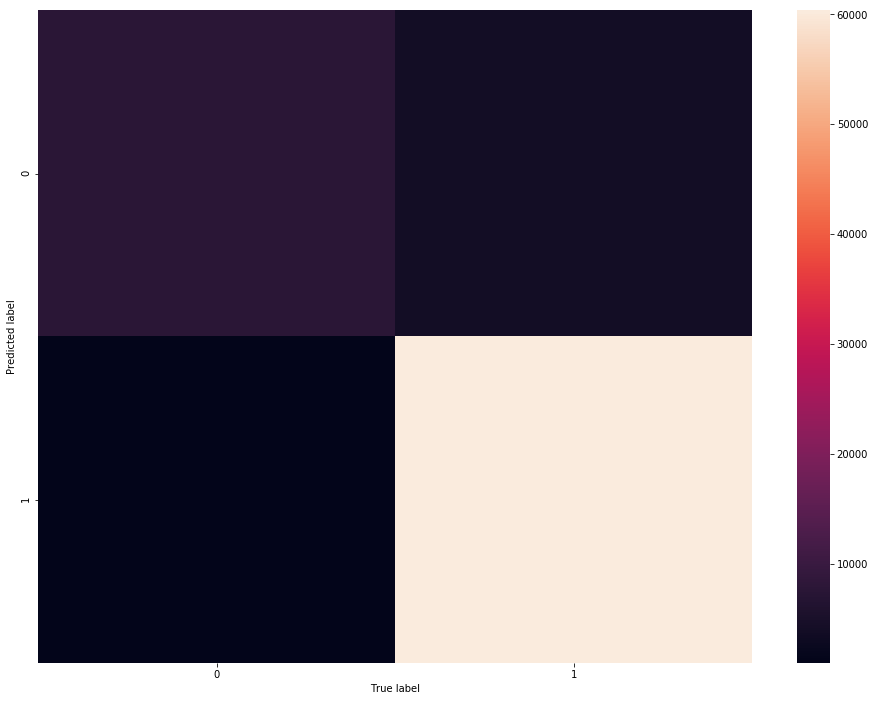

In [186]:
plt.figure(figsize=(16, 12))
sns.heatmap(cmat)
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [187]:
cmat

array([[ 7565,  3943],
       [  976, 60351]])

In [188]:
y_test.value_counts()

1    61327
0    11508
Name: target, dtype: int64

## Conclusion

This shows that out  of 61327 positive labels 60351 were predicted accurately, but only 7565 out of 11508 were predicted as negative class. This shows that it has high TPR and low TNR